# 1. 클러스터링
- Unsupervised Learning 기법입니다.
- 훈련 없이, 데이터를 그룹화하거나 클러스터로 군집화 하게 됩니다.
- 데이터를 특징에 따라 보다 가까운 클러스터로 할당해 묶게 된다.
- example
    - 소비자를 서로 다른 특징을 가진 segment로 분류해 마케팅에 적용 할 수 있습니다.
    - 병원에서 환자 특징 분류해서, 환자의 진단에 활용하기도 합니다.
 

# 2. 클러스터링 종류

## 2.1 분할 클러스터링(Partitioning Clustering)
- 클러스터의 개수 k를 미리 정하고, 데이터를 k의 그룹으로 구분합니다.
- 그룹은 분리되어 있고, 하나의 데이터는 하나의 그룹에만 속해 있을 수 있습니다.
- 데이터의 평균으로 계산된 중심점을 가지게 됩니다.
- k-Means 가 대표적인 분할 클러스터링입니다.


## 2.2 계층 클러스터링(Hierarchical Clustering)
- 미리 클러스터의 개수를 지정할 필요가 없습니다.
- Dendrogram 이라고 하는 나무 가지 모양으로 데이터를 구분합니다.

## 2.3 밀집도 기반 클러스터링(Density-based Clustering)
- 특정 지역에서의 밀집 정도에 따라 클러스터를 구분하는 기법입니다.
- 클러스터의 개수를 미리 지정할 필요가 없습니다.
- DBSCAN 이 밀집도 기반 클러스터링의 예시입니다.

# 3. k-Means


## 3.1 알고리즘
- 군집의 갯수 k를 정하고, 중심점$C_k$을 정합니다. 이 중심점은 반복하면서 갱신하게 됩니다.
- 반복
    - 할당 단계: 
        - 각 데이터 항목을 중심점과 얼마나 멀리 있는지 계산하여, 클러스터에 할당
    - 갱신 단계:
        - 현재 클러스터에 할당된 데이터로의 평균을 계산하여 새로운 클러스터 $C_k$의 중심점$m_k$를 설정
    - 종료 단계:
        - 갱신이 더 이상 없으면 종료

## 3.2 구현

**데이터**

구분 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 | 11 |
--|---|---|---|---|---|---|---|---|---|---|---|
x | 2 | 3 | 2 | 3 | 4 | 5 | 7 | 8 | 9 | 8 | 7 | 
y | 5 | 6 | 4 | 5 | 5 | 7 | 2 | 3 | 4 | 4 | 3 |

### 3.2.0 데이터 구성하기

In [5]:
import numpy as np
x = np.array([[2,5],[3,6],[2,4],[3,5],[4,5],[5,7],[7,2],[8,3],[9,4],[8,4],[7,3]])

In [6]:
xRdd = spark.sparkContext.parallelize(x)

In [8]:
xRdd.collect()

[array([2, 5]),
 array([3, 6]),
 array([2, 4]),
 array([3, 5]),
 array([4, 5]),
 array([5, 7]),
 array([7, 2]),
 array([8, 3]),
 array([9, 4]),
 array([8, 4]),
 array([7, 3])]

In [10]:
# 정수형으로 변경
kmeans_Rdd = xRdd.map(lambda x: [int(i) for i in x])

In [11]:
kmeans_Rdd.collect()

[[2, 5],
 [3, 6],
 [2, 4],
 [3, 5],
 [4, 5],
 [5, 7],
 [7, 2],
 [8, 3],
 [9, 4],
 [8, 4],
 [7, 3]]

In [12]:
kmeans_Df = kmeans_Rdd.toDF(["x","y"])
kmeans_Df.show()

+---+---+
|  x|  y|
+---+---+
|  2|  5|
|  3|  6|
|  2|  4|
|  3|  5|
|  4|  5|
|  5|  7|
|  7|  2|
|  8|  3|
|  9|  4|
|  8|  4|
|  7|  3|
+---+---+



### 3.2.1 Features 설정
- 클러스터링에 쓰이게 될 속성을 `VectorAssembler`로 묶어서 `features` 컬럼을 생성해주겠습니다.

In [13]:
from pyspark.ml.feature import VectorAssembler

va = VectorAssembler(inputCols=["x","y"],outputCol="features")

In [14]:
kmeans_Df1 = va.transform(kmeans_Df)

In [15]:
kmeans_Df1.printSchema()

root
 |-- x: long (nullable = true)
 |-- y: long (nullable = true)
 |-- features: vector (nullable = true)



In [16]:
kmeans_Df1.show(5)

+---+---+---------+
|  x|  y| features|
+---+---+---------+
|  2|  5|[2.0,5.0]|
|  3|  6|[3.0,6.0]|
|  2|  4|[2.0,4.0]|
|  3|  5|[3.0,5.0]|
|  4|  5|[4.0,5.0]|
+---+---+---------+
only showing top 5 rows



### 3.2.2 k-means 클러스터링

In [17]:
from pyspark.ml.clustering import KMeans

kmeans = KMeans(k=2)

In [18]:
model = kmeans.fit(kmeans_Df1)

### 3.2.3 클러스터 중심점

In [34]:
print(model.clusterCenters())
centroids = model.clusterCenters()

[array([7.8, 3.2]), array([3.16666667, 5.33333333])]


In [35]:
centroids = np.array(centroids)

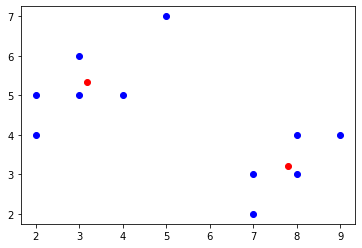

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.scatter(x[:,0],x[:,1],color='blue')
plt.scatter(centroids[:,0],centroids[:,1],color='red')

## 3.3 예제: iris 데이터 클러스터링 - RDD로 생성

### 3.3.0 데이터 불러오기

In [37]:
from sklearn import datasets

data = datasets.load_iris()

In [39]:
data = data['data']

### 3.3.1 RDD 생성

In [42]:
dataRdd = spark.sparkContext.parallelize(data)

In [43]:
dataRdd.take(3)

[array([5.1, 3.5, 1.4, 0.2]),
 array([4.9, 3. , 1.4, 0.2]),
 array([4.7, 3.2, 1.3, 0.2])]

### 3.3.2 형변환

In [44]:
dataRdd = dataRdd.map(lambda x: [float(i) for i in x])

In [45]:
dataRdd.take(3)

[[5.1, 3.5, 1.4, 0.2], [4.9, 3.0, 1.4, 0.2], [4.7, 3.2, 1.3, 0.2]]

### 3.3.3 k-Means 모델링


In [47]:
from pyspark.mllib.clustering import KMeans

model = KMeans.train(dataRdd, k = 2, maxIterations=10)

In [48]:
model.clusterCenters

[array([6.30103093, 2.88659794, 4.95876289, 1.69587629]),
 array([5.00566038, 3.36981132, 1.56037736, 0.29056604])]

## 3.4 예제: iris 데이터 클러스터링 - DataFrame으로 생성

### 3.4.0 데이터 불러오기

In [51]:
file_name = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"

In [52]:
import pandas as pd
iris = pd.read_csv(file_name, names=["sepal_length","sepal_width","petal_length", "petal_width","species"])

### 3.4.1 DataFrame 생성

In [54]:
irisDf = spark.createDataFrame(iris)

In [55]:
irisDf.describe().show()

+-------+------------------+------------------+------------------+------------------+--------------+
|summary|      sepal_length|       sepal_width|      petal_length|       petal_width|       species|
+-------+------------------+------------------+------------------+------------------+--------------+
|  count|               150|               150|               150|               150|           150|
|   mean| 5.843333333333334|             3.054| 3.758666666666667|1.1986666666666665|          null|
| stddev|0.8280661279778629|0.4335943113621736|1.7644204199522624|0.7631607417008411|          null|
|    min|               4.3|               2.0|               1.0|               0.1|   Iris-setosa|
|    max|               7.9|               4.4|               6.9|               2.5|Iris-virginica|
+-------+------------------+------------------+------------------+------------------+--------------+



### 3.4.2 features 생성

In [56]:
from pyspark.ml.feature import VectorAssembler

va = VectorAssembler(inputCols=["sepal_length", "sepal_width", "petal_length", "petal_width"], outputCol="features")
irisDf1 = va.transform(irisDf)

In [57]:
irisDf1.printSchema()

root
 |-- sepal_length: double (nullable = true)
 |-- sepal_width: double (nullable = true)
 |-- petal_length: double (nullable = true)
 |-- petal_width: double (nullable = true)
 |-- species: string (nullable = true)
 |-- features: vector (nullable = true)



In [58]:
irisDf1.show(3)

+------------+-----------+------------+-----------+-----------+-----------------+
|sepal_length|sepal_width|petal_length|petal_width|    species|         features|
+------------+-----------+------------+-----------+-----------+-----------------+
|         5.1|        3.5|         1.4|        0.2|Iris-setosa|[5.1,3.5,1.4,0.2]|
|         4.9|        3.0|         1.4|        0.2|Iris-setosa|[4.9,3.0,1.4,0.2]|
|         4.7|        3.2|         1.3|        0.2|Iris-setosa|[4.7,3.2,1.3,0.2]|
+------------+-----------+------------+-----------+-----------+-----------------+
only showing top 3 rows



### 3.4.3 k-Means 모델링

In [66]:
from pyspark.ml.clustering import KMeans
kmeans = (KMeans(k=3)
          .setFeaturesCol("features")
          .setPredictionCol("cluster")
         )

In [67]:
model = kmeans.fit(irisDf1)

In [68]:
print (model.clusterCenters())

[array([5.9016129 , 2.7483871 , 4.39354839, 1.43387097]), array([5.006, 3.418, 1.464, 0.244]), array([6.85      , 3.07368421, 5.74210526, 2.07105263])]


In [69]:
model.transform(irisDf1).show(150)

+------------+-----------+------------+-----------+---------------+-----------------+-------+
|sepal_length|sepal_width|petal_length|petal_width|        species|         features|cluster|
+------------+-----------+------------+-----------+---------------+-----------------+-------+
|         5.1|        3.5|         1.4|        0.2|    Iris-setosa|[5.1,3.5,1.4,0.2]|      1|
|         4.9|        3.0|         1.4|        0.2|    Iris-setosa|[4.9,3.0,1.4,0.2]|      1|
|         4.7|        3.2|         1.3|        0.2|    Iris-setosa|[4.7,3.2,1.3,0.2]|      1|
|         4.6|        3.1|         1.5|        0.2|    Iris-setosa|[4.6,3.1,1.5,0.2]|      1|
|         5.0|        3.6|         1.4|        0.2|    Iris-setosa|[5.0,3.6,1.4,0.2]|      1|
|         5.4|        3.9|         1.7|        0.4|    Iris-setosa|[5.4,3.9,1.7,0.4]|      1|
|         4.6|        3.4|         1.4|        0.3|    Iris-setosa|[4.6,3.4,1.4,0.3]|      1|
|         5.0|        3.4|         1.5|        0.2|    Iris-